In [55]:
import math
import torch
from torch import nn, optim
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch.utils.data import DataLoader

import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

import json, os, math
from tqdm import tqdm
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
import torchvision.transforms as transforms

# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

In [7]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [8]:
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [9]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)

In [10]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)

In [11]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

In [12]:
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

In [13]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

In [14]:
class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [31]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies

In [41]:
def get_data_loaders(data_dir, batch_size, train=False):
    if train:
        # train
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Resize((64, 64), antialias=True),
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.RandomResizedCrop((64, 64), scale=(0.8, 1.0), ratio=(
                 0.75, 1.3333333333333333), interpolation=2, antialias=True),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_data = datasets.ImageFolder(os.path.join(
            data_dir, "train/images_original/"), transform=transform)
        train_loader = DataLoader(
            train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Resize((64, 64), antialias=True),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        val_data = datasets.ImageFolder(os.path.join(
            data_dir, "val/images_original/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(
            data_dir, "test/images_original/"), transform=transform)
        val_loader = DataLoader(
            val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(
            test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [46]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10, checkpoint_path=None, save_path=None, save_interval=10, device="cuda"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Load model if checkpoint path is provided
    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_acc = checkpoint['best_acc']

    model.to(device)

    # Lists to store metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _ = model(inputs)
                    _, preds = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if (epoch % save_interval == 0 or epoch == num_epochs - 1) and save_path:
            save_filename = f"{save_path}/epoch_{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies
            }, save_filename)
            print(f"Model saved to {save_filename}")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [48]:
NUM_EPOCHS = 50

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48,  # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 64,
    "num_classes": 10,  # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

dataset_path = "../Data"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(
    dataset_path, 32, train=False)

model = ViTForClassfication(config)
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = LabelSmoothingCrossEntropy()
criterion.to(device)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    dataloaders={'train': train_loader, 'val': val_loader},
    dataset_sizes={'train': train_data_len, 'val': valid_data_len},
    num_epochs=NUM_EPOCHS,
    checkpoint_path=None,
    save_path="../Models/ViT",
    save_interval=10,
    device=device
)


Epoch 0/49
----------


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


train Loss: 2.3595 Acc: 0.1075


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


val Loss: 2.3552 Acc: 0.1500
Model saved to ../Models/ViT/epoch_0.pth

Epoch 1/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


train Loss: 2.2566 Acc: 0.1588


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


val Loss: 2.1713 Acc: 0.2100

Epoch 2/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


train Loss: 2.2285 Acc: 0.1837


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


val Loss: 2.1233 Acc: 0.1800

Epoch 3/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


train Loss: 2.1962 Acc: 0.1850


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


val Loss: 2.2819 Acc: 0.2000

Epoch 4/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


train Loss: 2.1652 Acc: 0.1850


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


val Loss: 2.1768 Acc: 0.1600

Epoch 5/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


train Loss: 2.2094 Acc: 0.1762


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


val Loss: 2.1204 Acc: 0.2200

Epoch 6/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


train Loss: 2.1597 Acc: 0.1850


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


val Loss: 2.0844 Acc: 0.2000

Epoch 7/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


train Loss: 2.1263 Acc: 0.2213


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


val Loss: 2.0571 Acc: 0.2300

Epoch 8/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


train Loss: 2.1359 Acc: 0.2062


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


val Loss: 2.1428 Acc: 0.2800

Epoch 9/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


train Loss: 2.1115 Acc: 0.2313


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


val Loss: 2.1083 Acc: 0.2400

Epoch 10/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


train Loss: 2.1237 Acc: 0.2200


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


val Loss: 2.0500 Acc: 0.2600
Model saved to ../Models/ViT/epoch_10.pth

Epoch 11/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


train Loss: 2.0665 Acc: 0.2487


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


val Loss: 1.9652 Acc: 0.3300

Epoch 12/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


train Loss: 2.0546 Acc: 0.2787


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


val Loss: 2.0060 Acc: 0.2800

Epoch 13/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


train Loss: 2.0523 Acc: 0.2700


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


val Loss: 1.9985 Acc: 0.2700

Epoch 14/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


train Loss: 2.0277 Acc: 0.2838


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


val Loss: 1.9650 Acc: 0.3000

Epoch 15/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


train Loss: 2.0022 Acc: 0.2988


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


val Loss: 2.1439 Acc: 0.2000

Epoch 16/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


train Loss: 2.0810 Acc: 0.2475


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


val Loss: 1.9546 Acc: 0.2500

Epoch 17/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


train Loss: 1.9956 Acc: 0.2950


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


val Loss: 1.9761 Acc: 0.3300

Epoch 18/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


train Loss: 1.9491 Acc: 0.3250


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


val Loss: 1.9756 Acc: 0.3100

Epoch 19/49
----------


100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


train Loss: 1.9845 Acc: 0.3162


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


val Loss: 1.8970 Acc: 0.3900

Epoch 20/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


train Loss: 1.9661 Acc: 0.3075


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


val Loss: 1.9979 Acc: 0.3000
Model saved to ../Models/ViT/epoch_20.pth

Epoch 21/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


train Loss: 1.9373 Acc: 0.3225


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


val Loss: 1.9757 Acc: 0.3400

Epoch 22/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.29it/s]


train Loss: 1.8990 Acc: 0.3550


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


val Loss: 1.9028 Acc: 0.3200

Epoch 23/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


train Loss: 1.8974 Acc: 0.3400


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


val Loss: 1.8475 Acc: 0.3700

Epoch 24/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


train Loss: 1.8557 Acc: 0.3812


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


val Loss: 1.8349 Acc: 0.4100

Epoch 25/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


train Loss: 1.8414 Acc: 0.3887


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


val Loss: 1.9773 Acc: 0.3400

Epoch 26/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


train Loss: 1.8310 Acc: 0.3700


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


val Loss: 1.7824 Acc: 0.4000

Epoch 27/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


train Loss: 1.8454 Acc: 0.3688


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


val Loss: 1.8378 Acc: 0.3400

Epoch 28/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


train Loss: 1.8227 Acc: 0.3875


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


val Loss: 1.8354 Acc: 0.3400

Epoch 29/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


train Loss: 1.7815 Acc: 0.4000


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


val Loss: 1.7734 Acc: 0.3400

Epoch 30/49
----------


100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


train Loss: 1.7904 Acc: 0.4037


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


val Loss: 1.8130 Acc: 0.3800
Model saved to ../Models/ViT/epoch_30.pth

Epoch 31/49
----------


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


train Loss: 1.7678 Acc: 0.4088


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


val Loss: 1.7770 Acc: 0.3800

Epoch 32/49
----------


100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


train Loss: 1.7918 Acc: 0.4012


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


val Loss: 1.7463 Acc: 0.4400

Epoch 33/49
----------


100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


train Loss: 1.7744 Acc: 0.3825


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


val Loss: 1.9116 Acc: 0.3800

Epoch 34/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


train Loss: 1.7505 Acc: 0.4150


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


val Loss: 1.7429 Acc: 0.4500

Epoch 35/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


train Loss: 1.7525 Acc: 0.4150


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


val Loss: 1.7880 Acc: 0.4600

Epoch 36/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


train Loss: 1.8094 Acc: 0.3750


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


val Loss: 1.8267 Acc: 0.4200

Epoch 37/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


train Loss: 1.7398 Acc: 0.4313


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


val Loss: 1.7261 Acc: 0.4200

Epoch 38/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


train Loss: 1.7462 Acc: 0.4263


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


val Loss: 1.6962 Acc: 0.4300

Epoch 39/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


train Loss: 1.7333 Acc: 0.4275


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


val Loss: 1.7826 Acc: 0.4500

Epoch 40/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


train Loss: 1.7281 Acc: 0.4175


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


val Loss: 1.7978 Acc: 0.3900
Model saved to ../Models/ViT/epoch_40.pth

Epoch 41/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


train Loss: 1.6891 Acc: 0.4450


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


val Loss: 1.6784 Acc: 0.4700

Epoch 42/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


train Loss: 1.6791 Acc: 0.4575


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


val Loss: 1.7653 Acc: 0.4000

Epoch 43/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


train Loss: 1.7502 Acc: 0.4250


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


val Loss: 1.6912 Acc: 0.4000

Epoch 44/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


train Loss: 1.6729 Acc: 0.4512


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


val Loss: 1.6902 Acc: 0.4500

Epoch 45/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


train Loss: 1.6865 Acc: 0.4750


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


val Loss: 1.6880 Acc: 0.5300

Epoch 46/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


train Loss: 1.6685 Acc: 0.4450


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


val Loss: 1.7071 Acc: 0.4100

Epoch 47/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


train Loss: 1.6755 Acc: 0.4575


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


val Loss: 1.7206 Acc: 0.4000

Epoch 48/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


train Loss: 1.6897 Acc: 0.4688


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


val Loss: 1.6644 Acc: 0.4200

Epoch 49/49
----------


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


train Loss: 1.6536 Acc: 0.4662


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

val Loss: 1.7305 Acc: 0.4600
Model saved to ../Models/ViT/epoch_49.pth

Training complete in 8m 47s
Best Val Acc: 0.5300


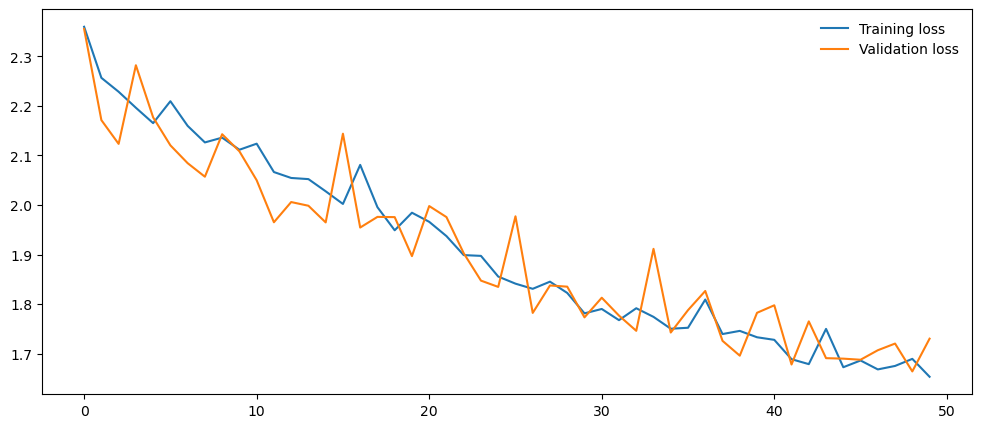

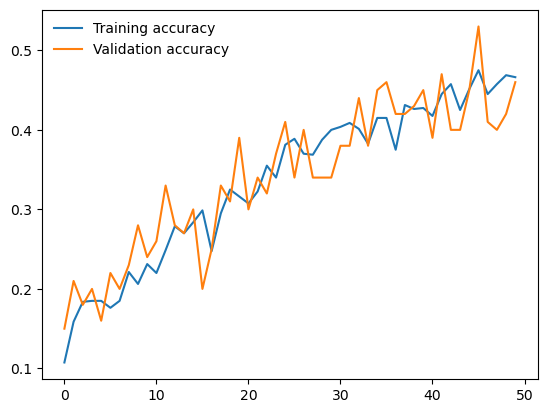

In [49]:
# Plotting
plt.figure(figsize=(12, 5))

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('../Output/ViT/vit_loss.png')
plt.show()

plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.savefig('../Output/ViT/vit_accuracy.png')
plt.show()

In [53]:
@torch.no_grad()
def visualize_attention(model, classes, test_loader, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    
    # Take random 30 images from the test loader
    images, labels = next(iter(test_loader))
    raw_images = images.clone()

    # images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    # images = images.to(device)
    # model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(64, 64), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((64, 64)), np.zeros((64, 64))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        # img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        # # ax.imshow(img)
        # show images
        img = np.transpose(raw_images[i].cpu().numpy(), (1, 2, 0))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((64, 64)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

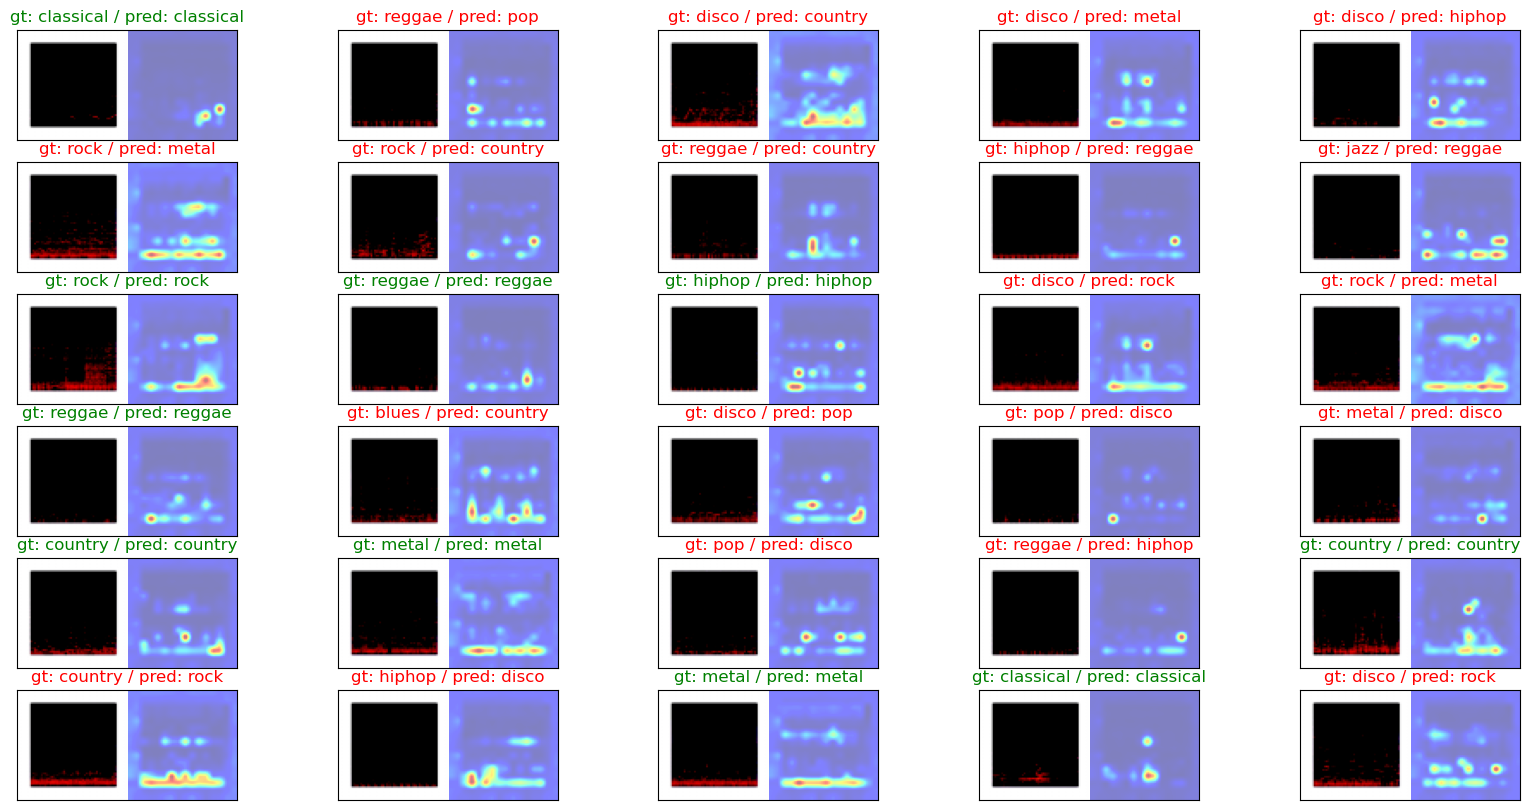

In [54]:
classes = get_classes(os.path.join(dataset_path, "train/images_original/"))
visualize_attention(model, classes, test_loader, output="../Output/ViT/attention.png")

In [57]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output, _ = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 4/4 [00:00<00:00,  5.10it/s]

Test Loss: 0.0980
Test Accuracy of blues: 10% ( 1/10)
Test Accuracy of classical: 70% ( 7/10)
Test Accuracy of country: 70% ( 7/10)
Test Accuracy of disco: 33% ( 3/ 9)
Test Accuracy of hiphop: 40% ( 4/10)
Test Accuracy of  jazz: 11% ( 1/ 9)
Test Accuracy of metal: 80% ( 8/10)
Test Accuracy of   pop: 10% ( 1/10)
Test Accuracy of reggae: 30% ( 3/10)
Test Accuracy of  rock: 50% ( 4/ 8)
Test Accuracy of 40% (39/96)
